<a href="https://colab.research.google.com/github/kalyaannnn/NLPReference/blob/main/NueralMachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
from datasets import load_dataset

data = load_dataset("kde4", lang1 = "en", lang2 = "fr")
data

Generating train split:   0%|          | 0/210173 [00:00<?, ? examples/s]

Dataset kde4 downloaded and prepared to /root/.cache/huggingface/datasets/kde4/en-fr-lang1=en,lang2=fr/0.0.0/243129fb2398d5b0b4f7f6831ab27ad84774b7ce374cf10f60f6e1ff331648ac. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [3]:
small = data["train"].shuffle(seed = 42).select(range(1_1000))

In [4]:
split = small.train_test_split(seed = 42)

In [5]:
from transformers import AutoTokenizer
checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.9/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [6]:
split["train"][0]

{'id': '40642',
 'translation': {'en': "Use file's modification as time of import",
  'fr': "Utiliser l'heure de modification du fichier comme heure d' importation"}}

In [7]:
en = split["train"][5]["translation"]["en"]
fr = split["train"][5]["translation"]["fr"]
en, fr

('Enter the denominator of your result',
 'Donner le dénominateur de votre résultat')

In [8]:
inputs = tokenizer(en)
inputs

{'input_ids': [12406, 4, 47518, 7, 117, 1018, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [9]:
with tokenizer.as_target_tokenizer():
  targets = tokenizer(fr)
targets

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:3596: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': [21616, 19, 47090, 5, 193, 3220, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [10]:
tokenizer.convert_ids_to_tokens(targets["input_ids"])

['▁Donner', '▁le', '▁dénominateur', '▁de', '▁votre', '▁résultat', '</s>']

In [11]:
bad_targets = tokenizer(fr)
tokenizer.convert_ids_to_tokens(bad_targets["input_ids"])

['▁Don',
 'ner',
 '▁le',
 '▁dé',
 'nom',
 'in',
 'ateur',
 '▁de',
 '▁vo',
 't',
 're',
 '▁ré',
 's',
 'ult',
 'at',
 '</s>']

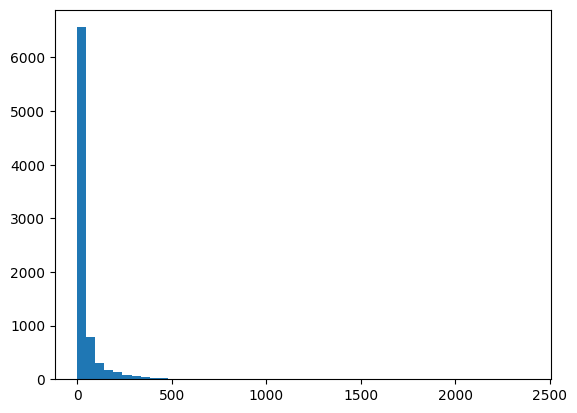

In [12]:
import matplotlib.pyplot as plt
train = split["train"]["translation"]
input_lens = [len(tr["en"]) for tr in train]
plt.hist(input_lens, bins = 50);

In [13]:
max_len_input = 128
max_tar_len = 128

def tokenize_fn(batch):
  inputs = [x["en"] for x in batch["translation"]]
  targets = [x["fr"] for x in batch["translation"]]

  tokenized_inputs = tokenizer(
      inputs, max_length = max_len_input, truncation = True
  )

  with tokenizer.as_target_tokenizer():
    tokenized_targets = tokenizer(
        targets, max_length = max_tar_len, truncation = True
    )

  tokenized_inputs["labels"] = tokenized_targets["input_ids"]
  return tokenized_inputs

In [14]:
tokenized_dataset = split.map(
    tokenize_fn,
    batched = True,
    remove_columns = split["train"].column_names,
)

Map:   0%|          | 0/8250 [00:00<?, ? examples/s]

Map:   0%|          | 0/2750 [00:00<?, ? examples/s]

In [15]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

In [16]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

In [17]:
[tokenized_dataset["train"][i] for i in range(1, 3)]

[{'input_ids': [23569, 34209, 7260, 20218, 452, 12815, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1],
  'labels': [1427,
   738,
   2,
   16550,
   22737,
   2,
   954,
   22861,
   352,
   3148,
   63,
   4662,
   1406,
   0]},
 {'input_ids': [1648, 16036, 0],
  'attention_mask': [1, 1, 1],
  'labels': [1648, 16036, 139, 0]}]

In [18]:
batch = data_collator([tokenized_dataset["train"][i] for i in range(1,3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [19]:
batch["labels"]

tensor([[ 1427,   738,     2, 16550, 22737,     2,   954, 22861,   352,  3148,
            63,  4662,  1406,     0],
        [ 1648, 16036,   139,     0,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100]])

In [20]:
batch["decoder_input_ids"]

tensor([[59513,  1427,   738,     2, 16550, 22737,     2,   954, 22861,   352,
          3148,    63,  4662,  1406],
        [59513,  1648, 16036,   139,     0, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513]])

In [21]:
tokenizer.convert_ids_to_tokens(batch["decoder_input_ids"][0])

['<pad>',
 '▁Or',
 'age',
 ',',
 '▁pluie',
 '▁modérée',
 ',',
 '▁g',
 'rê',
 'le',
 'we',
 'a',
 'ther',
 '▁condition']

In [22]:
tokenizer.convert_ids_to_tokens(batch["labels"][0])

['▁Or',
 'age',
 ',',
 '▁pluie',
 '▁modérée',
 ',',
 '▁g',
 'rê',
 'le',
 'we',
 'a',
 'ther',
 '▁condition',
 '</s>']

In [23]:
split['train'][1]

{'id': '102856',
 'translation': {'en': 'Thunderstorm Light Rain Hail',
  'fr': 'Orage, pluie modérée, grêleweather condition'}}

In [24]:
!pip install sacrebleu bert-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 9.5 MB/s eta 0:00:00


In [25]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")
bert_metric = load_metric("bertscore")

<ipython-input-25-ec0ba0363219>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [26]:
bleu_metric.compute(predictions=["I love cats"], references=[["I love cats"]])

{'score': 0.0,
 'counts': [3, 2, 1, 0],
 'totals': [3, 2, 1, 0],
 'precisions': [100.0, 100.0, 100.0, 0.0],
 'bp': 1.0,
 'sys_len': 3,
 'ref_len': 3}

In [27]:
bert_metric.compute(
    predictions=["I love cats"], references=[["I like cats"]], lang='en')

{'precision': [0.9803369045257568],
 'recall': [0.9803369045257568],
 'f1': [0.9803369045257568],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.28.1)'}

In [28]:
import numpy as np

def compute_metrics(preds_and_labels):
  preds, labels = preds_and_labels

  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens = True)

  labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens = True)

  decoded_preds = [pred.strip() for pred in decoded_preds]
  decoded_labels = [[label.strip()] for label in decoded_labels]

  bleu = bleu_metric.compute(
      predictions = decoded_preds, references = decoded_labels
  )
  bert_score = bert_metric.compute(
      predictions = decoded_preds, references = decoded_labels, lang = "fr"
  )

  return {"bleu": bleu["score"], 'bert_score': np.mean(bert_score['f1'])}

In [29]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
  "finetuned-model",
  evaluation_strategy="no",
  save_strategy="epoch",
  learning_rate=2e-5,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=64,
  weight_decay=0.01,
  save_total_limit=3,
  num_train_epochs=3,
  predict_with_generate=True,
  fp16=True,
)

In [31]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [33]:
trainer.evaluate(max_length=max_tar_len)

{'eval_loss': 1.701960563659668,
 'eval_bleu': 25.475144522125653,
 'eval_bert_score': 0.8437473256804726,
 'eval_runtime': 303.192,
 'eval_samples_per_second': 9.07,
 'eval_steps_per_second': 0.142}

In [34]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,1.343600


TrainOutput(global_step=774, training_loss=1.265808026611959, metrics={'train_runtime': 165.6765, 'train_samples_per_second': 149.387, 'train_steps_per_second': 4.672, 'total_flos': 493136993452032.0, 'train_loss': 1.265808026611959, 'epoch': 3.0})

In [36]:
trainer.save_model("my_saved_model")

In [37]:
from transformers import pipeline
translator = pipeline("translation", model='my_saved_model', device=0)

/usr/local/lib/python3.9/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [38]:
translator("I hope this course has helped you on your data science journey!")

[{'translation_text': "J'espère que ce cours vous a aidé dans votre parcours data science!"}]